<a href="https://colab.research.google.com/github/InMyDream21/Deep-Learning/blob/main/Tensorflow/zerotomastery/time_series/Time_series_forecasting_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict

In [ ]:
!nvidia-smi

Wed Mar  2 08:28:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin, we downloaded the data from coindesk

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-03-02 08:28:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2022-03-02 08:28:45 (6.04 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series with pandas

In [ ]:
# Import with pandas
import pandas as pd
# Lets read in our Bitcoin data and parse the dates
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # Parse the date column and tell pandas column 1 is a datetime

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


We've collected the historical price of Bitcoin for the past ~8 years but theres 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can thousands to tens of thousands to millions).

A smaller number of samples is something youll often runn into with time series data problems.

> **Note:** The **seasonality** of a tiem series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.

In [ ]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


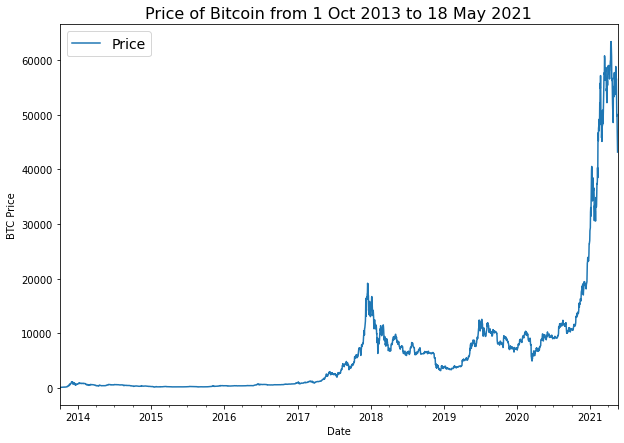

In [ ]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Importing time series data with Python's CSV module

In [ ]:
# Importing and Formatting historical Bitcoin data with Python
import csv
from datetime import datetime
timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # Skip first line (this gets rid of title columns)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as date not string
    btc_price.append(float(line[2])) # Get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

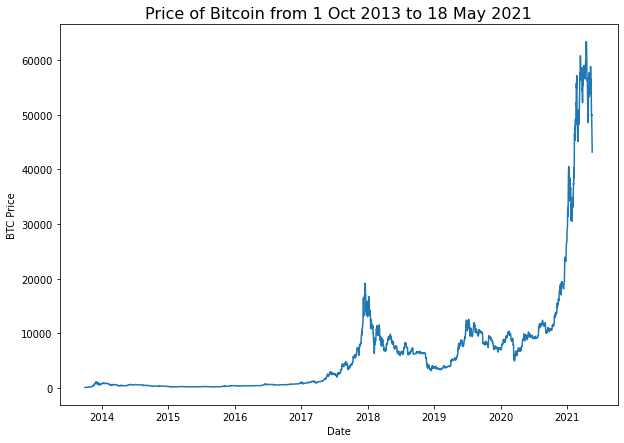

In [ ]:
#plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.ylabel("BTC Price")
plt.xlabel("Date");

## Format data part 1: Create train and test sets of our time series data

### Creating training and test sets with time series data (the wrong way)

In [ ]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [ ]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

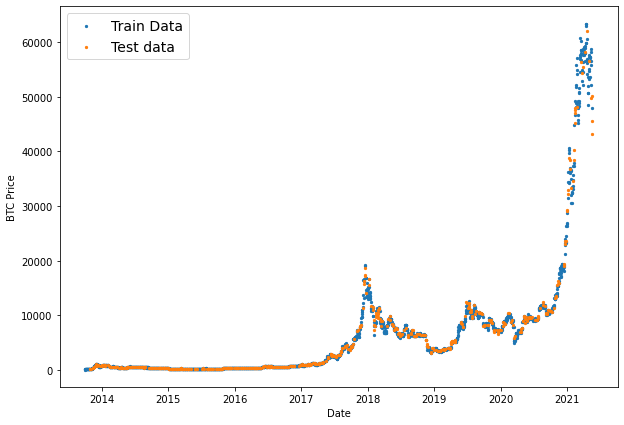

In [ ]:
# lets plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train Data")
plt.scatter(X_test, y_test, s = 5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create train & test sets for time series (the right way)

In [ ]:
# Create train and test splits the right way for tiem series data
split_size = int(0.8 * len(prices))

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

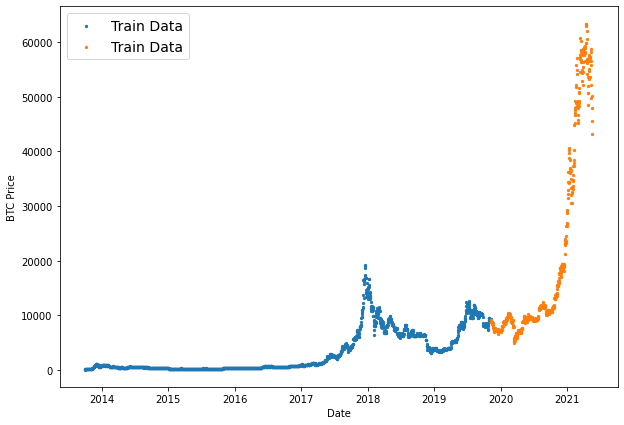

In [ ]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train Data")
plt.scatter(X_test, y_test, s=5, label="Train Data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Create a plotting function

Typing plotting code is tedious, lets functionize it.

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps)

  Parameters
  ----------
  timesteps : array of timestep values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (similar to start but for the end)
  label : label to show on plot about values, default None
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # Make label bigger
  plt.grid(True)

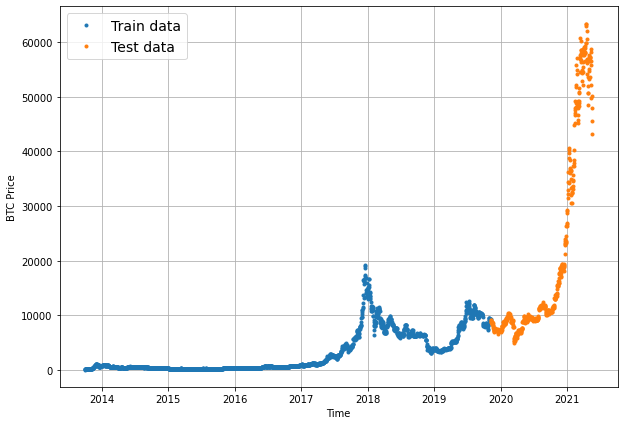

In [ ]:
# Test out plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict horizon


Modelling experiments we're running:
**Model, Horizon, window**
* 0	Naïve model (baseline),	NA	NA	NA
* 1	Dense model,	1,	7,	NA
* 2	Same as 1,	1,	30,	NA
* 3	Same as 1,	7,	30,	NA
* 4	Conv1D,	1,	7,	NA
* 5	LSTM,	1,	7,	NA
* 6	Same as 1 (but with multivariate data),	1,	7,	Block reward size
* 7	N-BEATs Algorithm,	1,	7,	NA
* 8	Ensemble (multiple models optimized on different loss functions),	1,	7,	NA
* 9	Future prediction model (model to predict future values),	1,	7,	NA
* 10 Same as 1 (but with turkey 🦃 data introduced),	1,	7,	NA

## Model 0: Naive Forecast (Model)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [ ]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

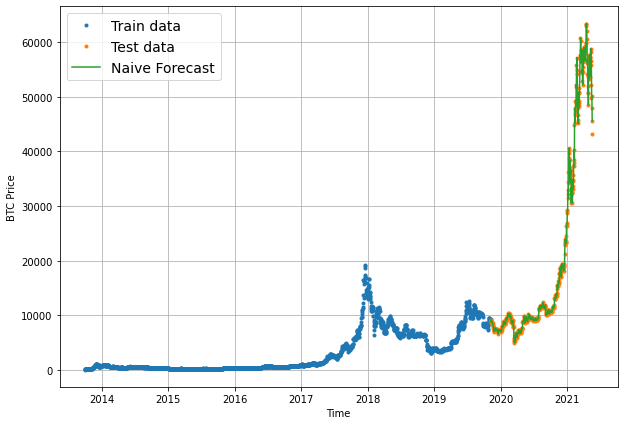

In [ ]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive Forecast")

## Evaluating a time series model

Lets look into some evaluation metrics for time series forecasting.

What are we doing?

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean squared error
* MAPE/sMAPE - (syummetric) mean absolute error
* MSE - mean absolute scaled error

For all of the above metrics, **lower is better**, for example, an MAE of 0 that is better than an MAE of 100.

The main thing we're evaluating here is: **how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?**

In [ ]:
import tensorflow as tf

In [ ]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # Our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season

In [ ]:
mean_absolute_scaled_error(y_test[1:], naive_forecast)

<tf.Tensor: shape=(), dtype=float64, numpy=0.9995699939182624>

In [ ]:
# Create a function to take in model predictions and truth values and return evaluation prediction
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)


  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

Thats one good looking evaluation function! 
lets now see if it works...

In [ ]:
naive_results = evaluate_preds(y_test[1:],
                               naive_forecast)

naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

## Format Data part 2: Windowing our dataset

Why do we window?

We window our time series dataset to turn our data into a supervised learning problem

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [ ]:
len(y_train)

2229

In [ ]:
# What we want to do with our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")


We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [ ]:
# Lets setup global variables for window and horizon size
HORIZON = 1 # Predict next day
WINDOW_SIZE = 7 # Use the past week of Bitcoin data to make the prediction

In [ ]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7]
  Output: [7] ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()}-> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6]-> Label: 7


We've got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above across our entire time series.

We could do this with python for loops, however, for large time series, that'd be quite slow.

To speed thing up, we'll leverage NumPy's array indexing.

Our function will:
1. Create a window step fo specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the hsitorical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

In [ ]:
# Create function to view numpy arrays as widnows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0) 

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes, window_indexes.shape}")

  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=HORIZON)
  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [ ]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


> **Note:** There's a function which does similar to the above in tf.keras.preprocesing, an extension could be to try and replicate what we've done using the premade function:
https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

## Turning windows into training and test sets

In [ ]:
# Make the train/test split
def make_train_test_split(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1 - test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

In [ ]:
np.squeeze(train_labels[:-HORIZON-1])

array([ 123.033     ,  124.049     ,  125.96116   , ..., 9369.62808116,
       9326.59962378, 9335.75240233])

In [ ]:
y_train[WINDOW_SIZE:]

array([ 123.033     ,  124.049     ,  125.96116   , ..., 9369.62808116,
       9326.59962378, 9335.75240233])

## Make a modelling checkpoint

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

In [ ]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiment"):
  return tf.keras.callbacks.ModelCheckpoint(os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

## Model 1: Dense model (window = 7, horizon = 1)

Out first depp model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLu
* An output layer with linear activation (no activation)
* Adam optimizer and MAE loss function
* Batch size of 128 (previously we've used 32)
* 100 epochs

In [ ]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {train_windows[i]} -> Label: {train_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

# 2. Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - 7s 154ms/step - loss: 780.3455 - mae: 780.3455 - mse: 2312725.7500 - val_loss: 2279.6526 - val_mae: 2279.6526 - val_mse: 12772728.0000
Epoch 2/100
18/18 [==============================] - 1s 72ms/step - loss: 247.6756 - mae: 247.6756 - mse: 285481.1875 - val_loss: 1005.9991 - val_mae: 1005.9991 - val_mse: 3441833.5000
Epoch 3/100
18/18 [==============================] - 1s 81ms/step - loss: 188.4116 - mae: 188.4116 - mse: 171891.5625 - val_loss: 923.2862 - val_mae: 923.2862 - val_mse: 2868220.5000
Epoch 4/100
18/18 [==============================] - 1s 68ms/step - loss: 169.4340 - mae: 169.4340 - mse: 151700.5625 - val_loss: 900.5872 - val_mae: 900.5872 - val_mse: 2683715.2500
Epoch 5/100
18/18 [==============================] - 1s 83ms/step - loss: 165.0895 - mae: 165.0895 - mse: 145490.7969 - val_loss: 895.2238 - val_mae: 895.2238 - val_mse: 2564574.0000
Epoch 6/100
18/18 [==============================] - 1s 83ms/step - loss: 158.

In [ ]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 585.9762 - mae: 585.9762 - mse: 1197803.1250


[585.9761962890625, 585.9761962890625, 1197803.125]

In [ ]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiment/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 568.9512 - mae: 568.9512 - mse: 1171744.0000


[568.951171875, 568.951171875, 1171744.0]

## Makin forecasts with a model (on the test dataset)

To make "forecasts" on the  test dataset (note: These wont be actual forecasts, they're only pseudo forecast because actual forecasts are into the future), lets write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. returns the predictions

In [ ]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [ ]:
# Make predictions using model_1 on the test dataset and evaluate it on test data
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8861.711, 8769.886, 9015.71 , 8795.517, 8723.809, 8730.11 ,
        8691.95 , 8502.054, 8460.961, 8516.547], dtype=float32)>)

In [ ]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 568.95123,
 'mape': 2.5448983,
 'mase': 0.9994897,
 'mse': 1171744.0,
 'rmse': 1082.4713}

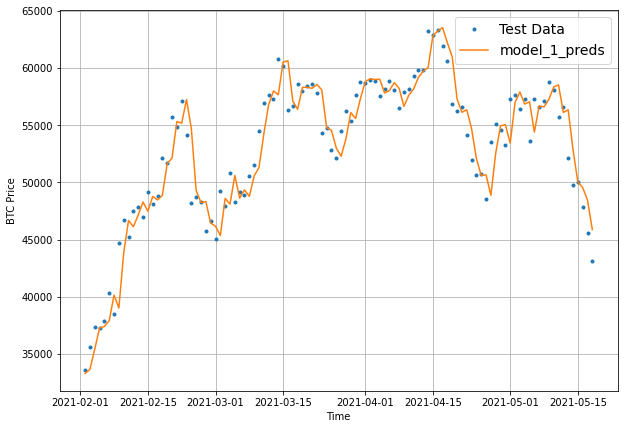

In [ ]:
# Lets plot our model 1 predictions
offset = 450
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset,
                 format="-",
                 label="model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)

In [ ]:
HORIZON = 1 # Predict one step at a time 
WINDOW_SIZE = 30 # Use 30 timesteps in past

In [ ]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [ ]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_split(windows=full_windows,
                                                                               labels=full_labels,
                                                                               test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [ ]:
train_windows[:3], train_labels[:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 137.92333, 142.95166, 152.55183, 160.33883,
         164.31499, 177

In [ ]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")
], name="model_2_dense")

# Compile model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# Fit the model
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiment/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiment

In [ ]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 608.9615 - mae: 608.9615 - mse: 1281438.8750


[608.9614868164062, 608.9614868164062, 1281438.875]

In [ ]:
# Load in the best performign model
model_2 = tf.keras.models.load_model("model_experiment/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 608.9615 - mae: 608.9615 - mse: 1281438.8750


[608.9614868164062, 608.9614868164062, 1281438.875]

In [ ]:
# Get forecat predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

In [ ]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 608.9615,
 'mape': 2.7693386,
 'mase': 1.0644706,
 'mse': 1281438.8,
 'rmse': 1132.0065}

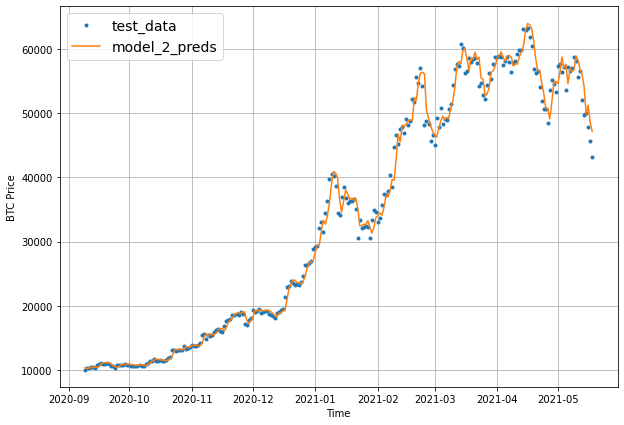

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account fot test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3: Dense (window = 30, horizon = 7)

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, 
                                                                               full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [ ]:
tf.random.set_seed(42)

# Create model
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")
], name="model_3_dense")

# Compile model
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_3.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiment/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiment

In [ ]:
# Evaluate the model
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1321.5201


1321.5201416015625

In [ ]:
model_3 = tf.keras.models.load_model("model_experiment/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1237.5063


1237.50634765625

In [ ]:
# Make predictions with model_3
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9004.693 , 9048.1   , 9425.088 , 9258.258 , 9495.798 , 9558.451 ,
        9357.354 ],
       [8735.507 , 8840.304 , 9247.793 , 8885.6   , 9097.188 , 9174.328 ,
        9156.819 ],
       [8672.508 , 8782.388 , 9123.8545, 8770.37  , 9007.13  , 9003.87  ,
        9042.723 ],
       [8874.398 , 8784.737 , 9043.901 , 8943.051 , 9033.479 , 9176.488 ,
        9039.676 ],
       [8825.891 , 8777.4375, 8926.779 , 8870.178 , 9213.232 , 9268.156 ,
        8942.485 ]], dtype=float32)>

In [ ]:
# Evaluate model_3 results
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([ 513.60516 ,  355.08356 ,  327.1702  ,  358.50977 ,  420.53207 ,
         537.8537  ,  545.6606  ,  485.92307 ,  584.4969  ,  687.3814  ,
         836.22675 ,  755.1571  ,  731.4959  ,  775.3398  ,  567.9547  ,
         266.80865 ,  188.80217 ,  188.1077  ,  253.09521 ,  301.4336  ,
         151.1075  ,  196.81432 ,  191.46184 ,  231.6506  ,  143.6114  ,
         122.59033 ,  132.78844 ,  190.81152 ,  179.1598  ,  228.25949 ,
         314.44028 ,  379.09283 ,  278.3254  ,  295.34604 ,  299.38525 ,
         248.64983 ,  299.75635 ,  259.6937  ,  180.30566 ,  206.72873 ,
         374.62906 ,  144.85135 ,  142.33607 ,  131.11572 ,   93.94057 ,
          54.825615,   73.7943  ,  103.59996 ,  121.33378 ,  168.67215 ,
         183.90945 ,  152.25307 ,  186.57129 ,  146.91309 ,  240.42955 ,
         351.00668 ,  540.9516  ,  549.15674 ,  521.2422  ,  526.8553  ,
         453.36307 ,  257.98166 ,  277.29492 ,  301.82465 ,  455.71756 ,
         458.96002 ,  503.44427 ,  522.3119 

## Make our evaluation function work for larger horizons

In [ ]:
# Create a function to take in model predictions and truth values and return evaluation prediction
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
model_3_results = evaluate_preds(tf.squeeze(test_labels),
                                 model_3_preds)
model_3_results

{'mae': 1237.5063,
 'mape': 5.5588784,
 'mase': 2.2020733,
 'mse': 5405198.5,
 'rmse': 1425.7479}

We've made and evaluated predictions with `model_3`, lets visualize, visualize, visualize!

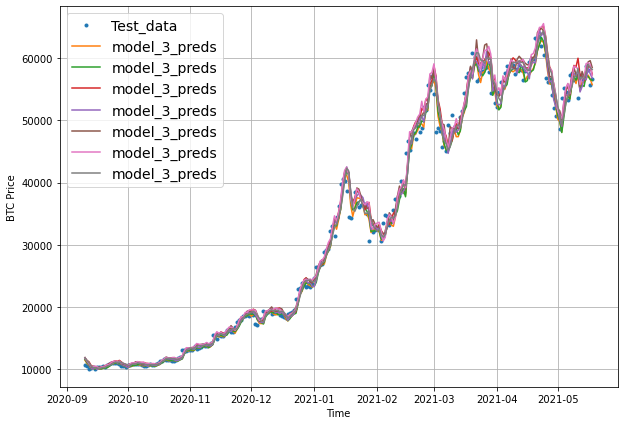

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_3_preds,
                 format="-",
                 start=offset, 
                 label="model_3_preds")

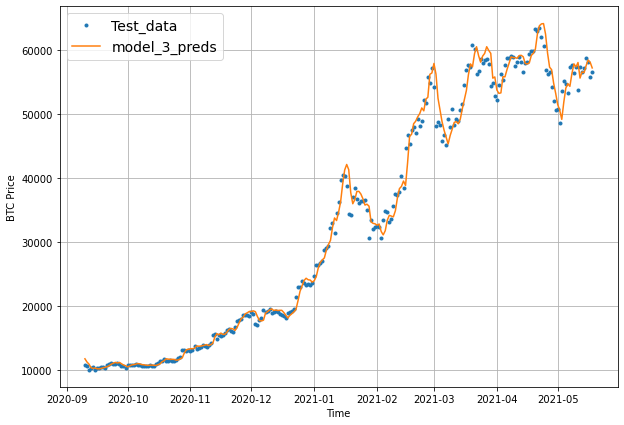

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 start=offset,
                 format="-",
                 label="model_3_preds")

## Which of our models is performing the best so far?

So we've trained a few models, now lets compate them and se how they've gone..

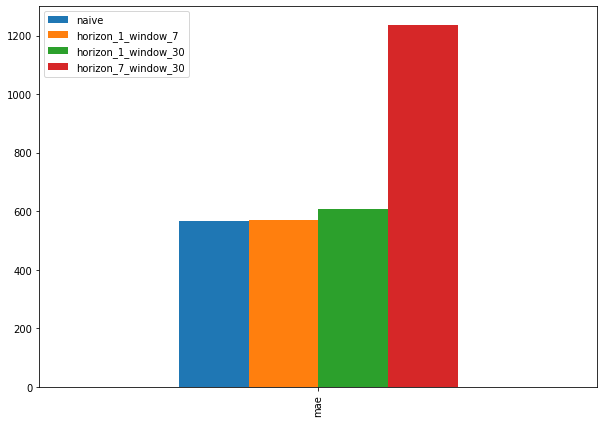

In [ ]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

## Model 4: Conv1D

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

To use the Conv1D layer, We need an input shape of: `(batch_size, timesteps, input_dim)`

However our data isn't in that shape yet..

In [ ]:
# Check data input shape
train_windows[0].shape

(7,)

In [ ]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works.
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [ ]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # Add an extra dimension for `input_dim`

In [ ]:
#Test out our lambda layer
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [ ]:
x.numpy()

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])

In [ ]:
tf.random.set_seed(42)

# Create Conv1D layer
model_4 = tf.keras.Sequential([
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
  layers.Conv1D(filters=128, kernel_size=7, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1d")

# Compile the model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_4.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

INFO:tensorflow:Assets written to: model_experiment/model_4_conv1d/assets
INFO:tensorflow:Assets written to: model_experiment/model_4_conv1d/assets
INFO:tensorflow:Assets written to: model_experiment/model_4_conv1d/assets
INFO:tensorflow:Assets written to: model_experiment/model_4_conv1d/assets
INFO:tensorflow:Assets written to: model_experiment/model_4_conv1d/assets
INFO:tensorflow:Assets written to: model_experiment/model_4_conv1d/assets
INFO:tensorflow:Assets written to: model_experiment/model_4_conv1d/assets
INFO:tensorflow:Assets written to: model_experiment/model_4_conv1d/assets
INFO:tensorflow:Assets written to: model_experiment/model_4_conv1d/assets
INFO:tensorflow:Assets written to: model_experiment/model_4_conv1d/assets
INFO:tensorflow:Assets written to: model_experiment/model_4_conv1d/assets
INFO:tensorflow:Assets written to: model_experiment/model_4_conv1d/assets
INFO:tensorflow:Assets written to: model_experiment/model_4_conv1d/assets
INFO:tensorflow:Assets written to: mod

In [ ]:
model_4.summary()

Model: "model_4_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            6400      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Evaluate model
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 615.6101


615.610107421875

In [ ]:
# Load back best performing model
model_4 = tf.keras.models.load_model("model_experiment/model_4_conv1d/")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 570.7388


570.7388305664062

In [ ]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8893.429, 8788.889, 9020.289, 8796.401, 8743.089, 8764.085,
       8680.323, 8538.85 , 8475.117, 8526.651], dtype=float32)>

In [ ]:
# Evaluate predictions
model_4_results = evaluate_preds(tf.squeeze(test_labels),
                                 model_4_preds)
model_4_results

{'mae': 570.7388,
 'mape': 2.5461204,
 'mase': 1.00263,
 'mse': 1183500.2,
 'rmse': 1087.888}

## Model 5: RNN (LSTM)

Lets build an RNN model for our time seeries data.

We'll yse the same data we've used before.

In [ ]:
tf.random.set_seed(42)

# Lets build am LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs, output, name="model_5_LSTM")

# Compile
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_5.name)])

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 2342.5518INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 4s 151ms/step - loss: 2323.6082 - val_loss: 9222.6523
Epoch 2/100
17/18 [===========================>..] - ETA: 0s - loss: 706.6636 INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 3s 154ms/step - loss: 695.4739 - val_loss: 1486.0555
Epoch 3/100
17/18 [===========================>..] - ETA: 0s - loss: 239.4237INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 139ms/step - loss: 237.3967 - val_loss: 1298.9084
Epoch 4/100
16/18 [=========================>....] - ETA: 0s - loss: 182.2439INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 143ms/step - loss: 181.9180 - val_loss: 966.6430
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 173.4022 - val_loss: 970.9295
Epoch 6/100
17/18 [===========================>..] - ETA: 0s - loss: 171.7026INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 140ms/step - loss: 173.5414 - val_loss: 941.4746
Epoch 7/100
17/18 [===========================>..] - ETA: 0s - loss: 171.3403INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 3s 159ms/step - loss: 170.3566 - val_loss: 898.5215
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 157.6712 - val_loss: 914.8641
Epoch 9/100
18/18 [==============================] - 0s 9ms/step - loss: 166.5143 - val_loss: 1079.0775
Epoch 10/100
17/18 [===========================>..] - ETA: 0s - loss: 161.4855INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 136ms/step - loss: 162.3369 - val_loss: 877.1689
Epoch 11/100
18/18 [==============================] - 0s 10ms/step - loss: 163.0841 - val_loss: 924.1126
Epoch 12/100
18/18 [==============================] - 0s 9ms/step - loss: 168.5598 - val_loss: 941.6025
Epoch 13/100
18/18 [==============================] - 0s 8ms/step - loss: 166.4727 - val_loss: 934.8435
Epoch 14/100
18/18 [==============================] - 0s 9ms/step - loss: 163.9537 - val_loss: 920.2159
Epoch 15/100
18/18 [==============================] - ETA: 0s - loss: 152.9470INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 136ms/step - loss: 152.9470 - val_loss: 856.2653
Epoch 16/100
18/18 [==============================] - 0s 9ms/step - loss: 147.4420 - val_loss: 898.9912
Epoch 17/100
18/18 [==============================] - 0s 9ms/step - loss: 151.0533 - val_loss: 943.1415
Epoch 18/100
18/18 [==============================] - 0s 9ms/step - loss: 157.8232 - val_loss: 924.0045
Epoch 19/100
18/18 [==============================] - 0s 9ms/step - loss: 155.9198 - val_loss: 911.4751
Epoch 20/100
18/18 [==============================] - 0s 9ms/step - loss: 155.6456 - val_loss: 862.6679
Epoch 21/100
18/18 [==============================] - 0s 9ms/step - loss: 153.1514 - val_loss: 862.5831
Epoch 22/100
18/18 [==============================] - 0s 9ms/step - loss: 151.4883 - val_loss: 863.8171
Epoch 23/100
18/18 [==============================] - 0s 9ms/step - loss: 150.7770 - val_loss: 886.8352
Epoch 24/100
18/18 [==============================] - 0s 9ms/step - loss: 1

INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 139ms/step - loss: 146.8467 - val_loss: 845.2780
Epoch 26/100
16/18 [=========================>....] - ETA: 0s - loss: 146.8793INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 3s 169ms/step - loss: 145.9843 - val_loss: 818.6807
Epoch 27/100
16/18 [=========================>....] - ETA: 0s - loss: 144.7295INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 140ms/step - loss: 144.4289 - val_loss: 804.3278
Epoch 28/100
17/18 [===========================>..] - ETA: 0s - loss: 142.4588INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 137ms/step - loss: 142.4610 - val_loss: 789.0858
Epoch 29/100
18/18 [==============================] - 0s 10ms/step - loss: 141.8738 - val_loss: 806.6756
Epoch 30/100
18/18 [==============================] - 0s 9ms/step - loss: 142.0521 - val_loss: 794.8835
Epoch 31/100
17/18 [===========================>..] - ETA: 0s - loss: 138.4295INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 3s 161ms/step - loss: 138.4690 - val_loss: 773.2811
Epoch 32/100
17/18 [===========================>..] - ETA: 0s - loss: 138.0486INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 140ms/step - loss: 137.1986 - val_loss: 772.2625
Epoch 33/100
18/18 [==============================] - 0s 9ms/step - loss: 135.9342 - val_loss: 786.4801
Epoch 34/100
16/18 [=========================>....] - ETA: 0s - loss: 136.0515INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 139ms/step - loss: 136.1931 - val_loss: 744.4506
Epoch 35/100
18/18 [==============================] - 0s 10ms/step - loss: 133.4514 - val_loss: 756.2968
Epoch 36/100
16/18 [=========================>....] - ETA: 0s - loss: 133.3179INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 140ms/step - loss: 134.0992 - val_loss: 735.1729
Epoch 37/100
18/18 [==============================] - 0s 10ms/step - loss: 130.6932 - val_loss: 745.9096
Epoch 38/100
17/18 [===========================>..] - ETA: 0s - loss: 129.4177INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 3s 162ms/step - loss: 129.2891 - val_loss: 717.2498
Epoch 39/100
18/18 [==============================] - 0s 9ms/step - loss: 129.6088 - val_loss: 719.0669
Epoch 40/100
18/18 [==============================] - 0s 10ms/step - loss: 129.6111 - val_loss: 732.0630
Epoch 41/100
17/18 [===========================>..] - ETA: 0s - loss: 128.0795INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 140ms/step - loss: 127.1393 - val_loss: 702.9354
Epoch 42/100
16/18 [=========================>....] - ETA: 0s - loss: 125.2375INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 138ms/step - loss: 125.6113 - val_loss: 700.8699
Epoch 43/100
18/18 [==============================] - 0s 9ms/step - loss: 125.9959 - val_loss: 704.3680
Epoch 44/100
18/18 [==============================] - 0s 9ms/step - loss: 125.2330 - val_loss: 719.1411
Epoch 45/100
14/18 [======================>.......] - ETA: 0s - loss: 125.4368INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 3s 158ms/step - loss: 129.0878 - val_loss: 687.3796
Epoch 46/100
18/18 [==============================] - 0s 10ms/step - loss: 124.9461 - val_loss: 706.3905
Epoch 47/100
16/18 [=========================>....] - ETA: 0s - loss: 122.7244INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 138ms/step - loss: 126.0465 - val_loss: 678.0845
Epoch 48/100
16/18 [=========================>....] - ETA: 0s - loss: 122.5795INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 141ms/step - loss: 123.9412 - val_loss: 677.1480
Epoch 49/100
18/18 [==============================] - 0s 9ms/step - loss: 123.1814 - val_loss: 700.9755
Epoch 50/100
18/18 [==============================] - 0s 9ms/step - loss: 125.1446 - val_loss: 725.7572
Epoch 51/100
18/18 [==============================] - 0s 9ms/step - loss: 125.5208 - val_loss: 780.1040
Epoch 52/100
17/18 [===========================>..] - ETA: 0s - loss: 123.7078INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 141ms/step - loss: 123.5061 - val_loss: 663.2543
Epoch 53/100
18/18 [==============================] - 0s 10ms/step - loss: 120.0524 - val_loss: 665.6277
Epoch 54/100
17/18 [===========================>..] - ETA: 0s - loss: 120.3596INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 3s 163ms/step - loss: 120.4394 - val_loss: 658.1812
Epoch 55/100
16/18 [=========================>....] - ETA: 0s - loss: 121.7435INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 137ms/step - loss: 118.6817 - val_loss: 650.8017
Epoch 56/100
16/18 [=========================>....] - ETA: 0s - loss: 120.7393INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 139ms/step - loss: 120.2385 - val_loss: 646.9162
Epoch 57/100
18/18 [==============================] - 0s 9ms/step - loss: 123.6108 - val_loss: 676.0363
Epoch 58/100
16/18 [=========================>....] - ETA: 0s - loss: 118.5885INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 138ms/step - loss: 118.2166 - val_loss: 642.8526
Epoch 59/100
18/18 [==============================] - 0s 9ms/step - loss: 117.8050 - val_loss: 644.1140
Epoch 60/100
16/18 [=========================>....] - ETA: 0s - loss: 118.5710INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 3s 162ms/step - loss: 118.0277 - val_loss: 640.6298
Epoch 61/100
18/18 [==============================] - 0s 11ms/step - loss: 117.6757 - val_loss: 674.2546
Epoch 62/100
18/18 [==============================] - 0s 9ms/step - loss: 120.8419 - val_loss: 736.8734
Epoch 63/100
18/18 [==============================] - 0s 9ms/step - loss: 122.4814 - val_loss: 641.0597
Epoch 64/100
18/18 [==============================] - 0s 8ms/step - loss: 115.6879 - val_loss: 665.2364
Epoch 65/100
16/18 [=========================>....] - ETA: 0s - loss: 117.4745INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 139ms/step - loss: 117.8764 - val_loss: 629.4848
Epoch 66/100
16/18 [=========================>....] - ETA: 0s - loss: 117.0592INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 141ms/step - loss: 115.7342 - val_loss: 627.8654
Epoch 67/100
15/18 [========================>.....] - ETA: 0s - loss: 114.6382INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 3s 157ms/step - loss: 116.0720 - val_loss: 624.9843
Epoch 68/100
18/18 [==============================] - 0s 10ms/step - loss: 115.8544 - val_loss: 626.7468
Epoch 69/100
15/18 [========================>.....] - ETA: 0s - loss: 119.5049INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 144ms/step - loss: 119.5743 - val_loss: 623.6360
Epoch 70/100
17/18 [===========================>..] - ETA: 0s - loss: 113.9016INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 140ms/step - loss: 115.2881 - val_loss: 623.5431
Epoch 71/100
18/18 [==============================] - 0s 10ms/step - loss: 114.6981 - val_loss: 640.9242
Epoch 72/100
16/18 [=========================>....] - ETA: 0s - loss: 115.9388INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 140ms/step - loss: 117.3488 - val_loss: 621.0178
Epoch 73/100
18/18 [==============================] - 0s 9ms/step - loss: 114.7942 - val_loss: 629.5701
Epoch 74/100
18/18 [==============================] - 0s 9ms/step - loss: 115.1500 - val_loss: 626.9415
Epoch 75/100
18/18 [==============================] - 0s 9ms/step - loss: 115.9312 - val_loss: 662.2502
Epoch 76/100
15/18 [========================>.....] - ETA: 0s - loss: 115.2776INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 3s 162ms/step - loss: 115.1412 - val_loss: 620.8359
Epoch 77/100
18/18 [==============================] - 0s 9ms/step - loss: 117.6456 - val_loss: 668.2390
Epoch 78/100
18/18 [==============================] - 0s 10ms/step - loss: 117.0707 - val_loss: 628.1731
Epoch 79/100
17/18 [===========================>..] - ETA: 0s - loss: 114.0470INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 141ms/step - loss: 113.6489 - val_loss: 610.1957
Epoch 80/100
18/18 [==============================] - 0s 9ms/step - loss: 113.0044 - val_loss: 624.5187
Epoch 81/100
18/18 [==============================] - 0s 9ms/step - loss: 113.2803 - val_loss: 632.4530
Epoch 82/100
17/18 [===========================>..] - ETA: 0s - loss: 114.8117INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 142ms/step - loss: 115.9831 - val_loss: 607.7241
Epoch 83/100
18/18 [==============================] - 0s 9ms/step - loss: 113.7448 - val_loss: 622.1393
Epoch 84/100
18/18 [==============================] - 0s 9ms/step - loss: 114.0071 - val_loss: 619.6950
Epoch 85/100
18/18 [==============================] - 0s 9ms/step - loss: 114.1199 - val_loss: 640.6756
Epoch 86/100
18/18 [==============================] - 0s 10ms/step - loss: 115.0656 - val_loss: 613.5978
Epoch 87/100
18/18 [==============================] - 0s 10ms/step - loss: 112.2010 - val_loss: 607.8956
Epoch 88/100
15/18 [========================>.....] - ETA: 0s - loss: 115.9324INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 143ms/step - loss: 112.1981 - val_loss: 601.7839
Epoch 89/100
18/18 [==============================] - 0s 10ms/step - loss: 112.8817 - val_loss: 647.1225
Epoch 90/100
18/18 [==============================] - 0s 9ms/step - loss: 118.4780 - val_loss: 660.7481
Epoch 91/100
18/18 [==============================] - 0s 11ms/step - loss: 118.6482 - val_loss: 685.7650
Epoch 92/100
18/18 [==============================] - 0s 10ms/step - loss: 114.3789 - val_loss: 622.2435
Epoch 93/100
15/18 [========================>.....] - ETA: 0s - loss: 116.6698INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 3s 165ms/step - loss: 113.3837 - val_loss: 599.4068
Epoch 94/100
18/18 [==============================] - 0s 10ms/step - loss: 111.0267 - val_loss: 600.6318
Epoch 95/100
17/18 [===========================>..] - ETA: 0s - loss: 110.5354INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 142ms/step - loss: 111.1373 - val_loss: 597.5020
Epoch 96/100
18/18 [==============================] - 0s 9ms/step - loss: 111.1646 - val_loss: 603.2917
Epoch 97/100
18/18 [==============================] - 0s 10ms/step - loss: 111.7010 - val_loss: 618.8985
Epoch 98/100
18/18 [==============================] - 0s 10ms/step - loss: 111.8481 - val_loss: 598.4055
Epoch 99/100
16/18 [=========================>....] - ETA: 0s - loss: 110.0667INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiment/model_5_LSTM/assets


18/18 [==============================] - 2s 142ms/step - loss: 110.7292 - val_loss: 596.6447
Epoch 100/100
18/18 [==============================] - 0s 9ms/step - loss: 112.5656 - val_loss: 597.1186


In [ ]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiment/model_5_LSTM/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 1s 3ms/step - loss: 596.6447


596.6446533203125

In [ ]:
# Make prediction with out LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8991.225, 8823.2  , 9009.359, 8847.859, 8742.254], dtype=float32)>

In [ ]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 596.64465,
 'mape': 2.6838453,
 'mase': 1.0481395,
 'mse': 1273486.9,
 'rmse': 1128.4888}

## Make a multivariate time series dataset

Before we add a feature to our time series, what is a feature we can use?

One feature we could add is whether or not Elon tweeted on that day..

* day 1 - 0
* day 2 - 1
* day 3 - 0

What's a better feature to use?

How about the bitcoin halving events?

In [ ]:
# Lets make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Lets add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isnt in our dataset (our data starts from 01 October 2013)
block_reward_2 = 25 # 8 Novermber 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [ ]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [ ]:
# Add in a block_reward_column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [ ]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [ ]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


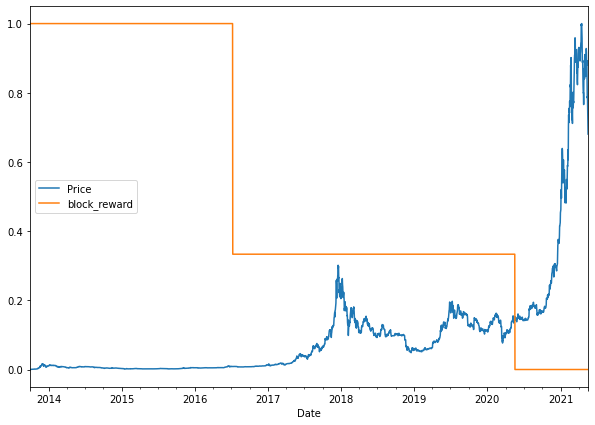

In [ ]:
# Plot the block reward vs price overtime
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                                  columns=bitcoin_prices_block.columns,
                                                  index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

## Making a windowed dataset with pandas

Previously, weve turned our univariate time series into windowed dataset using the helper function above.

However, wince we've now got multivariate data, these functions won't work.

Not to worry, we can use the pandas.DataFrame.shift() method to window our multivariate data.

In [ ]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


What we've done is created a way to window our dataset directly from a pandas dataframe.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
etc...
```

In [ ]:
# Create X (windows) and y (horizons) feature
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [ ]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Multivariate Model

In [ ]:
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_6_multivariate")

# Compile the model
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_6.fit(X_train,
            y_train,
            epochs=100,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_6.name)])

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 1234.6805INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 43ms/step - loss: 1234.6805 - val_loss: 2061.9080
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 351.5053INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 37ms/step - loss: 351.5053 - val_loss: 1908.6729
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 235.4153INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 34ms/step - loss: 235.4153 - val_loss: 1329.0585
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 271.0341INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 35ms/step - loss: 208.6112 - val_loss: 1102.1340
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 196.5770 - val_loss: 1107.8472
Epoch 6/100
18/18 [==============================] - ETA: 0s - loss: 187.2244INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 36ms/step - loss: 187.2244 - val_loss: 1036.1722
Epoch 7/100
18/18 [==============================] - ETA: 0s - loss: 182.0245INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 37ms/step - loss: 182.0245 - val_loss: 1019.2924
Epoch 8/100
18/18 [==============================] - ETA: 0s - loss: 175.7059INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 34ms/step - loss: 175.7059 - val_loss: 977.8487
Epoch 9/100
15/18 [========================>.....] - ETA: 0s - loss: 173.2386INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 36ms/step - loss: 170.1784 - val_loss: 954.4034
Epoch 10/100
17/18 [===========================>..] - ETA: 0s - loss: 163.4161INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 34ms/step - loss: 164.4430 - val_loss: 913.5146
Epoch 11/100
14/18 [======================>.......] - ETA: 0s - loss: 161.4382INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 35ms/step - loss: 158.6892 - val_loss: 874.2504
Epoch 12/100
16/18 [=========================>....] - ETA: 0s - loss: 151.8416INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 36ms/step - loss: 152.0732 - val_loss: 861.0414
Epoch 13/100
18/18 [==============================] - 0s 5ms/step - loss: 151.1057 - val_loss: 886.1201
Epoch 14/100
18/18 [==============================] - ETA: 0s - loss: 147.5482INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 35ms/step - loss: 147.5482 - val_loss: 837.8613
Epoch 15/100
18/18 [==============================] - ETA: 0s - loss: 142.3497INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 36ms/step - loss: 142.3497 - val_loss: 794.4784
Epoch 16/100
18/18 [==============================] - ETA: 0s - loss: 137.5206INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 37ms/step - loss: 137.5206 - val_loss: 778.4048
Epoch 17/100
16/18 [=========================>....] - ETA: 0s - loss: 133.6634INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 36ms/step - loss: 135.8191 - val_loss: 772.4528
Epoch 18/100
18/18 [==============================] - ETA: 0s - loss: 134.8562INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 53ms/step - loss: 134.8562 - val_loss: 747.4800
Epoch 19/100
18/18 [==============================] - 0s 6ms/step - loss: 130.3347 - val_loss: 761.0549
Epoch 20/100
18/18 [==============================] - ETA: 0s - loss: 128.6775INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 36ms/step - loss: 128.6775 - val_loss: 701.8977
Epoch 21/100
17/18 [===========================>..] - ETA: 0s - loss: 128.7350INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 35ms/step - loss: 129.5576 - val_loss: 691.0128
Epoch 22/100
18/18 [==============================] - ETA: 0s - loss: 125.8060INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 36ms/step - loss: 125.8060 - val_loss: 684.4119
Epoch 23/100
18/18 [==============================] - 0s 6ms/step - loss: 125.5263 - val_loss: 692.1294
Epoch 24/100
16/18 [=========================>....] - ETA: 0s - loss: 123.2350INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 36ms/step - loss: 122.4765 - val_loss: 674.2213
Epoch 25/100
16/18 [=========================>....] - ETA: 0s - loss: 124.1111INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 34ms/step - loss: 121.1171 - val_loss: 669.6445
Epoch 26/100
18/18 [==============================] - 0s 6ms/step - loss: 127.2623 - val_loss: 690.0408
Epoch 27/100
18/18 [==============================] - ETA: 0s - loss: 124.6204INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 36ms/step - loss: 124.6204 - val_loss: 643.9725
Epoch 28/100
18/18 [==============================] - 0s 5ms/step - loss: 118.2544 - val_loss: 656.2766
Epoch 29/100
17/18 [===========================>..] - ETA: 0s - loss: 117.4213INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 34ms/step - loss: 119.6374 - val_loss: 633.4545
Epoch 30/100
17/18 [===========================>..] - ETA: 0s - loss: 120.1284INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 36ms/step - loss: 119.5001 - val_loss: 625.3953
Epoch 31/100
18/18 [==============================] - 0s 5ms/step - loss: 114.5633 - val_loss: 668.5061
Epoch 32/100
17/18 [===========================>..] - ETA: 0s - loss: 117.6070INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 35ms/step - loss: 116.9750 - val_loss: 617.1060
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 115.2438 - val_loss: 649.0985
Epoch 34/100
18/18 [==============================] - 0s 5ms/step - loss: 114.5187 - val_loss: 632.1378
Epoch 35/100
15/18 [========================>.....] - ETA: 0s - loss: 116.0261INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 34ms/step - loss: 113.6357 - val_loss: 607.4173
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 115.2605 - val_loss: 626.4316
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 141.7286INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 36ms/step - loss: 113.7021 - val_loss: 606.2318
Epoch 38/100
17/18 [===========================>..] - ETA: 0s - loss: 111.8183INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 36ms/step - loss: 111.4061 - val_loss: 603.2919
Epoch 39/100
18/18 [==============================] - ETA: 0s - loss: 112.7722INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 35ms/step - loss: 112.7722 - val_loss: 596.0060
Epoch 40/100
18/18 [==============================] - ETA: 0s - loss: 110.5418INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 35ms/step - loss: 110.5418 - val_loss: 593.2170
Epoch 41/100
18/18 [==============================] - 0s 6ms/step - loss: 110.8671 - val_loss: 609.1066
Epoch 42/100
18/18 [==============================] - 0s 6ms/step - loss: 115.7249 - val_loss: 607.4875
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 111.3313 - val_loss: 606.2031
Epoch 44/100
18/18 [==============================] - ETA: 0s - loss: 109.7027INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 35ms/step - loss: 109.7027 - val_loss: 586.1214
Epoch 45/100
18/18 [==============================] - 0s 6ms/step - loss: 107.8748 - val_loss: 593.8447
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 109.8641 - val_loss: 586.4578
Epoch 47/100
18/18 [==============================] - 0s 6ms/step - loss: 112.3587 - val_loss: 655.4485
Epoch 48/100
18/18 [==============================] - 0s 6ms/step - loss: 109.1614 - val_loss: 598.7232
Epoch 49/100
18/18 [==============================] - 0s 6ms/step - loss: 109.3029 - val_loss: 589.2487
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 111.1971 - val_loss: 649.3792
Epoch 51/100
18/18 [==============================] - 0s 5ms/step - loss: 110.8514 - val_loss: 602.7665
Epoch 52/100
18/18 [==============================] - 0s 7ms/step - loss: 111.8331 - val_loss: 599.2959
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 11

INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 35ms/step - loss: 110.4069 - val_loss: 575.7751
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 108.6609 - val_loss: 785.9759
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 124.9824 - val_loss: 670.3788
Epoch 58/100
18/18 [==============================] - 0s 6ms/step - loss: 112.8591 - val_loss: 580.2875
Epoch 59/100
18/18 [==============================] - 0s 5ms/step - loss: 107.2513 - val_loss: 597.5087
Epoch 60/100
18/18 [==============================] - 0s 5ms/step - loss: 109.2322 - val_loss: 632.2953
Epoch 61/100
18/18 [==============================] - 0s 5ms/step - loss: 109.3519 - val_loss: 591.5410
Epoch 62/100
18/18 [==============================] - 0s 5ms/step - loss: 108.4084 - val_loss: 617.5808
Epoch 63/100
18/18 [==============================] - 0s 6ms/step - loss: 113.5326 - val_loss: 613.1470
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 11

INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 35ms/step - loss: 112.0475 - val_loss: 575.5543
Epoch 66/100
18/18 [==============================] - 0s 6ms/step - loss: 111.2830 - val_loss: 590.7806
Epoch 67/100
18/18 [==============================] - 0s 6ms/step - loss: 106.7917 - val_loss: 586.8845
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 112.2987 - val_loss: 696.5294
Epoch 69/100
18/18 [==============================] - 0s 6ms/step - loss: 124.7808 - val_loss: 698.5267
Epoch 70/100
18/18 [==============================] - 0s 6ms/step - loss: 119.3443 - val_loss: 581.2104
Epoch 71/100
18/18 [==============================] - 0s 6ms/step - loss: 109.9960 - val_loss: 607.6739
Epoch 72/100
16/18 [=========================>....] - ETA: 0s - loss: 104.9060INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 37ms/step - loss: 106.7710 - val_loss: 573.6144
Epoch 73/100
18/18 [==============================] - 0s 5ms/step - loss: 110.2485 - val_loss: 618.8955
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 105.5330 - val_loss: 574.9454
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 107.3177 - val_loss: 606.1973
Epoch 76/100
18/18 [==============================] - 0s 5ms/step - loss: 107.8084 - val_loss: 582.2406
Epoch 77/100
18/18 [==============================] - ETA: 0s - loss: 107.2528INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 36ms/step - loss: 107.2528 - val_loss: 571.8563
Epoch 78/100
18/18 [==============================] - 0s 6ms/step - loss: 106.2309 - val_loss: 572.2827
Epoch 79/100
18/18 [==============================] - 0s 6ms/step - loss: 105.8568 - val_loss: 596.5464
Epoch 80/100
18/18 [==============================] - 0s 6ms/step - loss: 107.8419 - val_loss: 577.2399
Epoch 81/100
18/18 [==============================] - ETA: 0s - loss: 105.1101INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 35ms/step - loss: 105.1101 - val_loss: 568.4897
Epoch 82/100
18/18 [==============================] - 0s 5ms/step - loss: 114.1867 - val_loss: 592.5613
Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 107.9631 - val_loss: 651.6219
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 109.6690 - val_loss: 568.9339
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 105.8219 - val_loss: 571.5331
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 104.8628 - val_loss: 579.3857
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 104.7148 - val_loss: 582.9182
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 106.8899 - val_loss: 569.0820
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 105.4376 - val_loss: 569.3439
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 10

INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 54ms/step - loss: 104.2910 - val_loss: 568.2687
Epoch 96/100
18/18 [==============================] - 0s 5ms/step - loss: 106.5346 - val_loss: 606.5489
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 107.1290 - val_loss: 585.3787
Epoch 98/100
18/18 [==============================] - 0s 6ms/step - loss: 105.8151 - val_loss: 574.4833
Epoch 99/100
17/18 [===========================>..] - ETA: 0s - loss: 106.1799INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiment/model_6_multivariate/assets


18/18 [==============================] - 1s 36ms/step - loss: 105.8276 - val_loss: 567.5863
Epoch 100/100
18/18 [==============================] - 0s 5ms/step - loss: 114.9743 - val_loss: 654.9892


In [ ]:
# Evaluate model
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 654.9892


654.9891967773438

In [ ]:
# Load in and evaluate best performing model
model_6 = tf.keras.models.load_model("model_experiment/model_6_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 567.5862


567.5862426757812

In [ ]:
# Make predictions
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8836.276, 8763.8  , 9040.486, 8741.225, 8719.326], dtype=float32)>

In [ ]:
# EValuate predictions to get eval metrics
model_6_results = evaluate_preds(y_test,
                                 model_6_preds)
model_6_results

{'mae': 567.5863,
 'mape': 2.5413754,
 'mase': 0.99709195,
 'mse': 1161687.2,
 'rmse': 1077.816}

In [ ]:
model_1_results

{'mae': 568.95123,
 'mape': 2.5448983,
 'mase': 0.9994897,
 'mse': 1171744.0,
 'rmse': 1082.4713}

## Model 7: N-BEATS algorithm

Lets now try build the bigget baddest (though maybe not the baddest, as in, it performs really well..) time series forecasting model we've built so far.

### Building and testing the N-BEATS block layer

In [ ]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int, 
               theta_size: int, 
               horizon: int,
               n_neurons: int, 
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLu activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu")for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and the forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

Lets test our NBeatsBlock class.

To do so we'll make some dummy inputs and outputs.

In [ ]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # Input shape to the model has to reflect dense layer input requirements (ndims = 2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.19014978  0.83798355 -0.32870018  0.25159916 -0.47540277 -0.77836645
 -0.5299447 ]
Forecast: -0.7554212808609009


### Preparing data for the N-BEATS algorithm using `tf.data`

To make our input data load as fast as possible we're going to be adhering to the performant data pipeline steps in the tf.data guide.

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create NBEATS data inputs (N-BEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
# Make features and labels 
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [ ]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and feature by zipping together
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

In [ ]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Before we can craft our N-BEATS model, we need two layers for the residual connections (subtract and add).

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture (section 3.2 on N-BEATS paper).

In [ ]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input Tensors: {tensor_1.numpy()} and {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input Tensors: [10 11 12 13 14 15 16 17 18 19] and [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the keras Functional API)
3. Make the initial backcast and forecast for the model with the layer created in (1)
4. Use for loop to create stacks of block layers
5. Use the `NBeatsBlock class` withing the for loop in (4) to create bock which return backcast and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use the MAE to keep it inline with our other models) and Adam optimizers with default setting as per section 5.2 of the N-BEATS paper.
9. Fit the N-BEATS for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * Early Stopping - because the model will be training for so long. we'll stop it early if it stops improving
  * Reduce LR on Plateau - if a model stops improving, try lowering the learning rate to reduce the amount it updates its weights ecah time (take smaller steps towards best performance)

In [ ]:
%%time

tf.random.set_seed(42)

# 1. Setup an instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

#2. Create input to stack
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input") 

#3. Create initial backcast and forecast input (backwards prediction + horizon predictions)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. CReate stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # First stack is already created in (3)
  
  # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # Pass in the residuals

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_nbeats")

# 8. Compile model with MAE loss
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# 9. Fit the model with earlystopping and reducelronplateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            patience=100,
                                                            verbose=1)])


Epoch 653: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 924: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1024: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 6min 12s, sys: 11.2 s, total: 6min 23s
Wall time: 8min 15s


In [ ]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 45ms/step - loss: 571.2784


571.2784423828125

In [ ]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8852.919, 8776.099, 9019.317, 8778.263, 8749.184, 8736.593,
       8662.998, 8508.501, 8469.714, 8510.916], dtype=float32)>

In [ ]:
# Evaluate N-BEATS model preds
model_7_results = evaluate_preds(y_test,
                                 model_7_preds)
model_7_results

{'mae': 571.27844,
 'mape': 2.5655324,
 'mase': 1.003578,
 'mse': 1170477.6,
 'rmse': 1081.8861}

### Plotting the N-BEATS architecture we've created

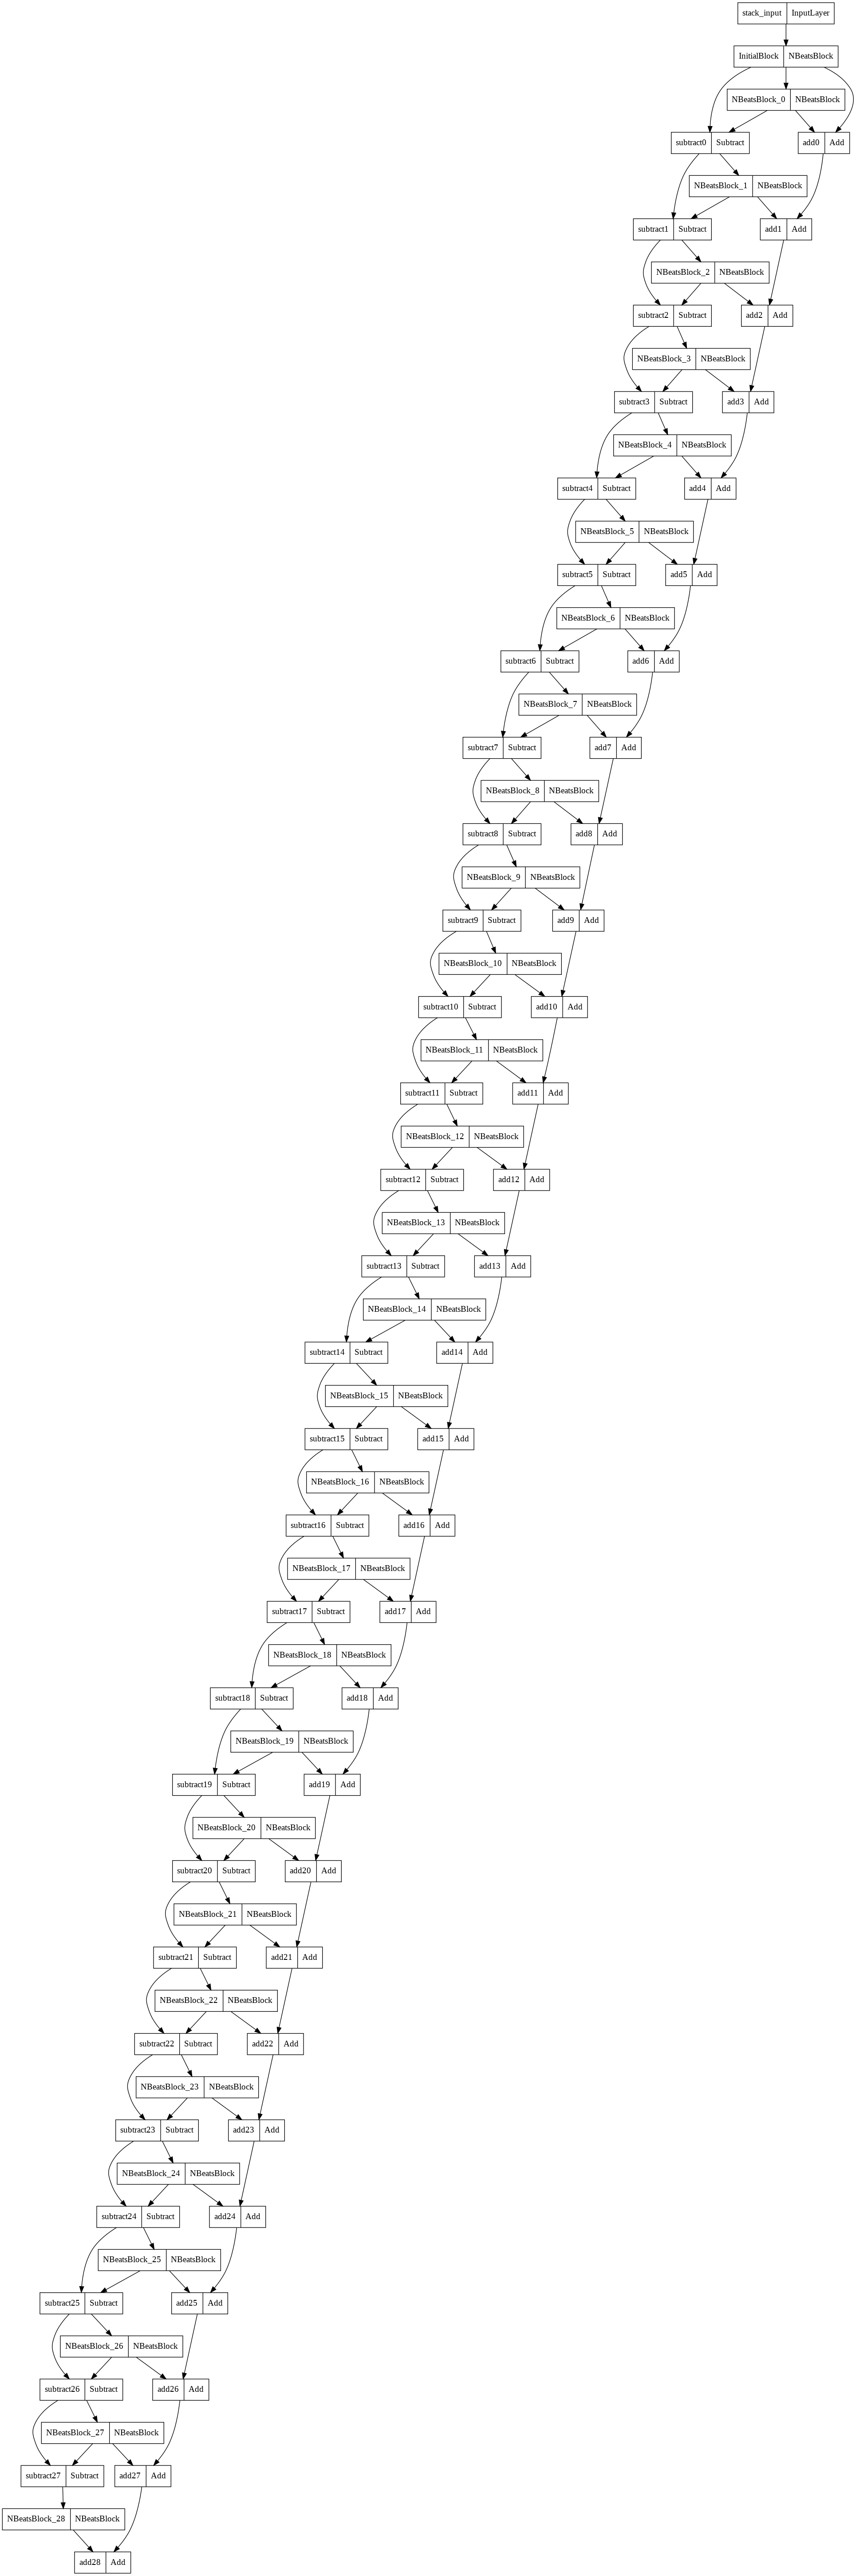

In [ ]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8: Creating an ensemble (stacking different models together)

An ensemble leverages the wisdom of the crowd effect.

It combines many *different* models to predict a common goal.

### Constructing and fitting an ensemble of models (using different loss function)

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(loss_fn)
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
      for loss_function in loss_fns:
        print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

        # Construct a simple model (similar to model_1)
        model = tf.keras.Sequential([
          # Initialize dense layers with normal distribution for estimating prediction intervals later on
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(HORIZON)
        ])

        # Compile simple mode lwith current loss function
        model.compile(loss=loss_function,
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["mae", "mse"])
        
        # Fit the current model
        model.fit(train_data,
                  epochs=num_epochs,
                  verbose=0,
                  validation_data=test_data,
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                              patience=200,
                                                              restore_best_weights=True),
                             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                  patience=100,
                                                                  verbose=1)])
        
        # Append fitted model to list of ensemble model
        ensemble_models.append(model)

  return ensemble_models

In [ ]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 884: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 996: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 591: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 707: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 807: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 165: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 282: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 382: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 409: ReduceLROnPl

### Make predictions with our ensemble model

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds=[]

  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

CPU times: user 781 ms, sys: 37.6 ms, total: 819 ms
Wall time: 786 ms


In [ ]:
ensemble_preds

<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8801.961 ,  8773.979 ,  9027.686 , ..., 50183.355 , 49296.06  ,
        46701.848 ],
       [ 8772.935 ,  8746.485 ,  9053.332 , ..., 49354.33  , 48557.45  ,
        45361.984 ],
       [ 8732.5205,  8719.164 ,  9094.259 , ..., 49907.418 , 47981.164 ,
        45304.367 ],
       ...,
       [ 8928.954 ,  8760.196 ,  9028.9795, ..., 49350.766 , 49633.97  ,
        46425.93  ],
       [ 8725.811 ,  8801.662 ,  9100.766 , ..., 49573.33  , 48521.953 ,
        45032.363 ],
       [ 8823.228 ,  8768.265 ,  9047.374 , ..., 49764.926 , 48099.258 ,
        45879.63  ]], dtype=float32)>

In [ ]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean

<tf.Tensor: shape=(556,), dtype=float32, numpy=
array([ 8788.279 ,  8771.615 ,  9059.082 ,  8722.454 ,  8740.319 ,
        8713.665 ,  8660.506 ,  8474.858 ,  8453.76  ,  8522.334 ,
        8199.272 ,  8101.3433,  8044.729 ,  7623.3506,  7272.7266,
        7299.5674,  7080.63  ,  7204.2354,  7109.2915,  7534.4487,
        7374.998 ,  7739.081 ,  7550.675 ,  7389.0156,  7316.741 ,
        7308.577 ,  7201.021 ,  7385.868 ,  7503.7217,  7534.8716,
        7538.337 ,  7324.338 ,  7226.9946,  7173.55  ,  7182.3643,
        7227.681 ,  7079.908 ,  7098.1187,  6868.087 ,  6585.725 ,
        7395.6274,  7167.826 ,  7170.1025,  7255.75  ,  7264.917 ,
        7184.752 ,  7213.331 ,  7206.0835,  7175.7563,  7208.1304,
        7302.5205,  7379.8823,  7241.328 ,  7164.369 ,  7155.8765,
        6945.79  ,  7275.071 ,  7329.1465,  7358.6074,  7698.17  ,
        8061.23  ,  8127.5933,  7849.5312,  8088.549 ,  8090.921 ,
        8166.4844,  8092.2544,  8739.159 ,  8883.223 ,  8762.838 ,
        8934.0

In [ ]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median

array([ 8793.002 ,  8768.333 ,  9047.374 ,  8718.145 ,  8751.807 ,
        8722.183 ,  8656.227 ,  8475.62  ,  8461.6455,  8522.739 ,
        8199.041 ,  8103.5977,  8051.882 ,  7613.231 ,  7270.071 ,
        7295.218 ,  7074.571 ,  7194.6187,  7122.3906,  7522.9897,
        7382.2617,  7738.516 ,  7557.484 ,  7397.669 ,  7323.0947,
        7302.979 ,  7195.8125,  7389.0947,  7497.461 ,  7536.135 ,
        7543.916 ,  7334.8135,  7233.9775,  7173.044 ,  7185.0464,
        7224.7393,  7083.9443,  7103.6196,  6873.942 ,  6575.0996,
        7388.4854,  7162.574 ,  7180.6094,  7263.195 ,  7247.416 ,
        7190.272 ,  7211.8677,  7205.2407,  7179.215 ,  7207.9062,
        7303.2036,  7377.511 ,  7250.9155,  7175.842 ,  7157.4004,
        6942.236 ,  7269.777 ,  7319.958 ,  7360.8374,  7703.7617,
        8057.7134,  8123.571 ,  7851.079 ,  8084.5215,  8099.8564,
        8172.677 ,  8094.8477,  8751.399 ,  8887.355 ,  8764.748 ,
        8941.604 ,  8958.696 ,  8665.43  ,  8626.477 ,  8684.4

In [ ]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_test, ensemble_mean)
ensemble_results

{'mae': 567.2021,
 'mape': 2.581882,
 'mase': 0.996417,
 'mse': 1143167.8,
 'rmse': 1069.1903}

In [ ]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_test, ensemble_median)
ensemble_results

{'mae': 567.4191,
 'mape': 2.579682,
 'mase': 0.9967983,
 'mse': 1150474.1,
 'rmse': 1072.6016}

### Plotting the prediction intervals (uncertainty estimates) of our ensemble

So far we've been making point predictions with our models.

E.g. horizon = 1, our model predicts tomorrow's price of Bitcoin will be $50,000 USD

Wouldnt it be helpful if we knew a range of where that prediction came from?

Instead of 50,000 USD on the dot, how about 48,000 - 52,000

One way to get the 95% confidence prediction intervals for a deep learning is the bootstrap method:
1. Take the prediction from a number of randomly initialized models (we've got this thanks to our ensemble models)
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96 (assuming the distribution is Gaussian/Normal, 95% of observation fall within 1.96 standard deviation of the mean)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)

In [ ]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions from a number of randomly initialized models

  #2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std

  # 4. Get the prediction interval upper and lower bound
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

In [ ]:
# Get the upper and lower bounds of the 95% prediction interval
lower, upper = get_upper_lower(preds=ensemble_preds)

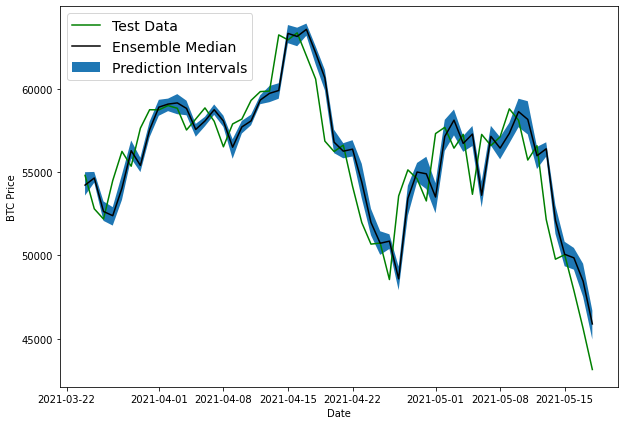

In [ ]:
# Get the median/mean values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset = 500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
# To plot the upper and lower bounds lets use fill_between
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

Hmm...

So far all of our models predictions have been lagging behind the test data...

As if they're replicating what the naive model does and just predict the previous timestep as the next timestep.

> **Note:** These prediction intervals are estimates themselves. And they have been created with the assumption that our models data is from a normal distribution.

## Aside: two types of uncertainty (coconut and subway)

Uncertainty estimates in machine learning seek out to qualitatively and quantitatively answer the questions:
1. What can my model know? (with perfect data, what's possible for a model to learn?)
2. What doesn't my model know? (What can a model never predict? Or would it be helpful if a model could tell you that when it's making a prediction, it doesn't actually know if it's right or not?)

There are two major types of uncertainty in machine learning you should know about:
* **Aleatoric uncertainty** - this type of uncertainty cannot be reduced and it is often referred as "data" uncertainty or "subway" uncertainty
* **Epistemic uncertainty** - this type of uncertainty can be reduced, it is also referred to as "model" or "coconut" uncertainty

## Model 9: Train a model on the full historical data to make predictions into the future

So far all of our models have predicted on the test dataset, however, this is only a pseudofuture.

let's now build a model which is capable of predicting into the future!

In [ ]:
HORIZON = 1 
WINDOW_SIZE = 7

In [ ]:
# Train model on entire data to make prediction for the next day
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()

# Get labels
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

len(X_all), len(y_all)

(2780, 2780)

In [ ]:
X_all[:5], y_all[:5]

(array([[121.795  , 120.65533, 121.33866, 118.67466, 108.58483, 125.455  ,
         123.65499],
        [123.033  , 121.795  , 120.65533, 121.33866, 118.67466, 108.58483,
         125.455  ],
        [124.049  , 123.033  , 121.795  , 120.65533, 121.33866, 118.67466,
         108.58483],
        [125.96116, 124.049  , 123.033  , 121.795  , 120.65533, 121.33866,
         118.67466],
        [125.27966, 125.96116, 124.049  , 123.033  , 121.795  , 120.65533,
         121.33866]]),
 array([123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ]))

In [ ]:
# Turn data into efficient running tensors

features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
tf.random.set_seed(42)

# Create model
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_9_future")

# Compile model
model_9.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_9.fit(dataset_all,
            epochs=100,
            verbose=0)

### Make predictions into future

In [ ]:
# How many timesteps to predict into the future
INTO_FUTURE = 14

To make predictions into the future we want a function which:
1. Take as input:
  * a list of values (Bitcoin historical data)
  * a trained model (such as `model_9`)
  * a window into the future to predict (our `INTO_FUTURE` variable)
  * the window size a model was trained (`WINDOW_SIZE`) - The model can only predict on the same kind of data it was trained on
2. Creates an empty list for future forecasts this will be returned at the end of the function when it's full of predictions and extracts the last `WINDOW_SIZE` values from the input values
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` sequences which update to remove the first value and append the last prediction


In [ ]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecast into_future steps after values ends.

  Returns future forecast as a list of floats.
  """
  # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-window_size:]

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):
    # Predict on last window then append it again, again, again (our model will eventually start to make forecast on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-window_size:]

  return future_forecast

In [ ]:
# Make forecast into the future 
future_forecast = make_future_forecast(values=y_all,
                                        model=model_9,
                                        into_future=INTO_FUTURE,
                                        window_size=WINDOW_SIZE)

Predicting on:
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55764.46484375

Predicting on:
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55764.46484375] -> Prediction: 50985.9453125

Predicting on:
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55764.46484375 50985.9453125 ] -> Prediction: 48522.96484375

Predicting on:
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55764.46484375 50985.9453125  48522.96484375] -> Prediction: 48137.203125

Predicting on:
 [47885.62525472 45604.61575361 43144.47129086 55764.46484375
 50985.9453125  48522.96484375 48137.203125  ] -> Prediction: 47880.63671875

Predicting on:
 [45604.61575361 43144.47129086 55764.46484375 50985.9453125
 48522.96484375 48137.203125   47880.63671875] -> Prediction: 46879.71875

Predicting on:
 [43144.47129086 55764.46484375 50985.9453125  48522.96484375


## Plot future forecast

In [ ]:
future_forecast

[55764.465,
 50985.945,
 48522.965,
 48137.203,
 47880.637,
 46879.72,
 48227.6,
 53963.69,
 49685.56,
 47596.176,
 48114.43,
 48808.008,
 48623.855,
 50178.723]

In [ ]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values rangin from start_date to start_date + into_future
  """
  start_date = start_date + np.timedelta64(offset, "D") # Specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # Specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start and end date

In [ ]:
# Last timestep of timesteps (currently np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [ ]:
# Get next two week of timesteps
next_time_steps = get_future_dates(last_timestep, INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [ ]:
# Insert last timestep/final price into next timesteps and future forecast so the plot doesn't look janky
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55764.465, 50985.945, 48522.965, 48137.203, 47880.637,
        46879.72 , 48227.6  , 53963.69 , 49685.56 , 47596.176, 48114.43 ,
        48808.008, 48623.855, 50178.723], dtype=float32))

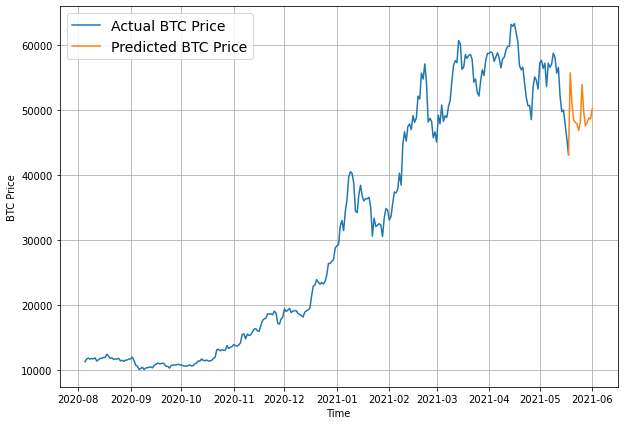

In [ ]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

## Model 10: Why forecasting is BS (The turkey problem)

In [ ]:
# Lets introduce a turkey problem to our BTC data(price of BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [ ]:
# Manufacture an extra price on the end (to showcase our Turkey problem)
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [ ]:
# Get the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

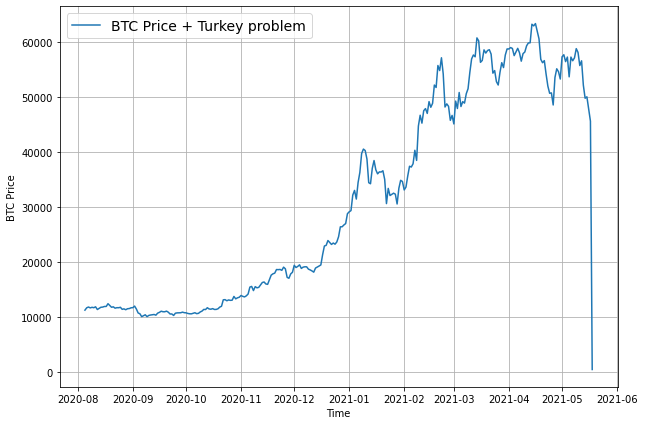

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC Price + Turkey problem",
                 start=2500)

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)

X_train, X_test, y_train, y_test = make_train_test_split(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

### Build a turkey model (moedl to predcit on turkey data)

In [ ]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "model_10_turkey_model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train, 
                 y_train,
                 epochs=100,
                 verbose=0,
                 batch_size=128,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiment/model_10_turkey_model/assets


In [ ]:
# Evaluate model on test data
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 719.4105


719.4105224609375

In [ ]:
# Load best performing turkey model and evaluate on test data
turkey_model = tf.keras.models.load_model("model_experiment/model_10_turkey_model/")
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 640.1680


640.16796875

In [ ]:
# Make predictions with turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8841.26 , 8774.641, 9015.577, 8770.346, 8745.853, 8723.038,
       8660.737, 8532.631, 8443.05 , 8517.348], dtype=float32)>

In [ ]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

{'mae': 17126.209,
 'mape': 121.31486,
 'mase': 26.502863,
 'mse': 614238300.0,
 'rmse': 23709.021}

In [ ]:
model_1_results

{'mae': 568.95123,
 'mape': 2.5448983,
 'mase': 0.9994897,
 'mse': 1171744.0,
 'rmse': 1082.4713}

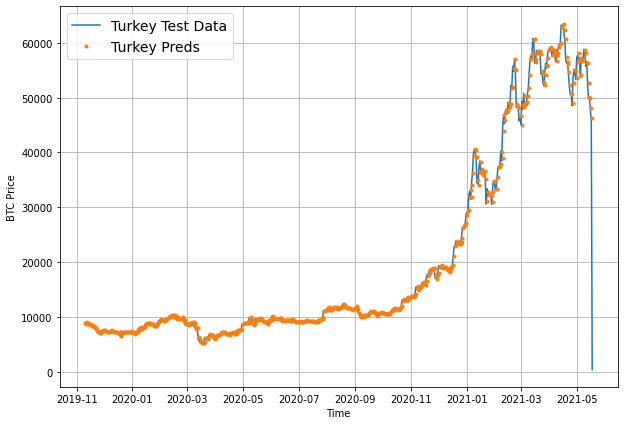

In [ ]:
plt.figure(figsize=(10, 7))
offset = 300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format="-",
                 label="Turkey Test Data")
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 label="Turkey Preds");

In [ ]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results, 
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_7_NBEATS": model_7_results,
                              "model_8_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results

,mae,mse,rmse,mape,mase
naive_model,567.980225,1.147547e+06,1071.236206,2.516525,0.999570
model_1_dense_w7_h1,568.951233,1.171744e+06,1082.471313,2.544898,0.999490
model_2_dense_w30_h1,608.961487,1.281439e+06,1132.006470,2.769339,1.064471
model_3_dense_w30_h7,1237.506348,5.405198e+06,1425.747925,5.558878,2.202073
model_4_CONV1D,570.738770,1.183500e+06,1087.887939,2.546120,1.002630
model_5_LSTM,596.644653,1.273487e+06,1128.488770,2.683845,1.048139
model_6_multivariate,567.586304,1.161687e+06,1077.816040,2.541375,0.997092
model_7_NBEATS,571.278442,1.170478e+06,1081.886108,2.565532,1.003578
model_8_ensemble,567.419128,1.150474e+06,1072.601562,2.579682,0.996798
model_10_turkey,17126.208984,6.142383e+08,23709.021484,121.314857,26.502863


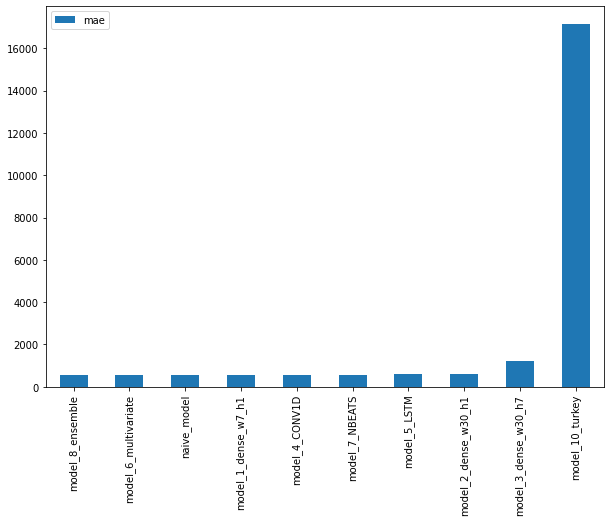

In [ ]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");